# O Problema de Portfólio de Markowitz

O objetivo deste tutorial é dar alguns detalhes a mais sobre a representação dos problemas de otimização em JuMP, e introduzir variáveis duais.

## Pacotes necessários

Este tutorial requer os seguintes pacotes:

In [1]:
using JuMP
import Ipopt

## Formulação

O [problema de portfólio de Markowitz](https://en.wikipedia.org/wiki/Markowitz_model)
é outro problema clássico de otimização: dado um conjunto de ativos financeiros,
com retorno médio $\mu_i$ e matriz de covariância $\Sigma_{i,j}$, queremos determinar
as proporções $w_i$ a serem investidas em cada ativo, maximizando o retorno
e minimizando a variância do portfólio.

Este problema possui 3 (!) formulações distintas.

1. Podemos minimizar a variância do portfólio, sujeito a um retorno mínimo:
$$
\begin{aligned}
\min \; & w^\top \Sigma w \\
\text{s.t.} \; & \sum_{i=1}^n w_i = 1, \\
        & \mu^\top w \geq R
\end{aligned}
$$

2. Podemos maximizar o retorno, contanto que o portfólio tenha variância limitada:
$$
\begin{aligned}
\max \; & \mu^\top w \\
\text{s.t.} \; & \sum_{i=1}^n w_i = 1, \\
        & w^\top \Sigma w \leq \sigma^2
\end{aligned}
$$

3. Podemos maximizar o retorno, **penalizando** a variância do portfólio:
$$
\begin{aligned}
\max \; & \mu^\top w - \lambda w^\top \Sigma w\\
\text{s.t.} \; & \sum_{i=1}^n w_i = 1,
\end{aligned}
$$

## Dados

Precisamos, apenas, do vetor de retornos médios $\mu$ e da matriz de covariância $\Sigma$.
Vamos usar dados sintéticos para ilustrar o problema, mas na prática eles são estimados
a partir de dados históricos.

In [2]:
μ = [0.05, 0.12, 0.09, 0.05, 0.15];
Σ = [
    0.01     0.004    0.006     0.002    0.0065
    0.004    0.04    -0.006     0.0064   0.0156
    0.006   -0.006    0.0225   -0.0012   0.00585
    0.002    0.0064  -0.0012    0.0064   0.00312
    0.0065   0.0156   0.00585   0.00312  0.0169
];

In [3]:
# Número de ativos
n = length(μ);

## Formulação JuMP

In [4]:
m = Model(Ipopt.Optimizer);
@variable(m, w[1:n] >= 0);
@constraint(m, sum(w) == 1);
@constraint(m, sum(w.*μ) >= 0.1);
@objective(m, Min, w'*Σ*w);
m

A JuMP Model
├ solver: Ipopt
├ objective_sense: MIN_SENSE
│ └ objective_function_type: QuadExpr
├ num_variables: 5
├ num_constraints: 7
│ ├ AffExpr in MOI.EqualTo{Float64}: 1
│ ├ AffExpr in MOI.GreaterThan{Float64}: 1
│ └ VariableRef in MOI.GreaterThan{Float64}: 5
└ Names registered in the model
  └ :w

In [5]:
set_silent(m)
optimize!(m)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [6]:
solution_summary(m)

* Solver : Ipopt

* Status
  Result count       : 1
  Termination status : LOCALLY_SOLVED
  Message from the solver:
  "Solve_Succeeded"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Objective value    : 6.58680e-03
  Dual objective value : 1.31736e-02

* Work counters
  Solve time (sec)   : 1.39999e-02
  Barrier iterations : 11


Note que
* não investimos nada no segundo ativo, apesar de ele ter um retorno médio maior do que $0.1$;
* investimos no terceiro e quartos ativos, apesar deles terem retornos médios menores do que $0.1$.

In [7]:
[value.(w) μ]

5×2 Matrix{Float64}:
 1.26334e-6  0.05
 3.34419e-6  0.12
 0.176011    0.09
 0.394391    0.05
 0.429593    0.15

A variância do portfólio é, também, relativamente baixa, se comparada às variâncias de cada ativo (que estão na diagonal de $\Sigma$):

In [8]:
print([Σ[i,i] for i in 1:n])
objective_value(m)

[0.01, 0.04, 0.0225, 0.0064, 0.0169]

0.006586801781185453

## Exercícios

- Altere a constante de normalização para 100, em vez de 1.
  * O que acontece com os valores da solução?
  * E com os valores das variáveis duais?
  * Como interpretar os números obtidos?
- Se você tiver R\$ 1500,00 para investir, você pode tanto calcular as proporções $w_i$,
  quanto calcular os valores absolutos $x_i$ a serem investidos em cada ativo.
  Qual a relação entre $w_i$ e $x_i$?

## Terminologia

Até agora, temos duas noções diferentes de "variável" quando fazemos otimização:
- A primeira, é a **variável de decisão** do problema, que é o que estamos tentando encontrar.
  No caso do problema de portfólio, são as proporções $w_i$ a serem investidas em cada ativo.
  Estas variáveis existem "na matemática".
- A segunda, é a variável `w` que criamos no código.
  Ela é uma representação computacional da variável de decisão, e é usada para comunicar
  com o _solver_.
  Por isto, ao resolver o problema, o JuMP modifica **estruturas internas** de forma que,
  ao chamar a função `value()` em uma variável, ela retorna o valor encontrado pelo solver.

## Análise de sensibilidade

Uma questão importante, para a prática, é a **análise de sensibilidade**, que estuda como a solução muda quando mudamos os dados do problema, como por exemplo o vetor de retornos médios $\mu$, a matriz de covariância $\Sigma$ ou o valor do retorno mínimo esperado.

In [9]:
risco = objective_value(m)

0.006586801781185453

Vejamos o que acontece se modificamos o lado direito da restrição de retorno esperado para 0.11:

In [10]:
m2 = Model(Ipopt.Optimizer);
@variable(m2, w[1:n] >= 0);
@constraint(m2, sum(w) == 1);
@constraint(m2, sum(w.*μ) >= 0.11);
@objective(m2, Min, w'*Σ*w);
optimize!(m2)
novo_risco = objective_value(m2)

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        5
Number of nonzeros in inequality constraint Jacobian.:        5
Number of nonzeros in Lagrangian Hessian.............:       15

Total number of variables............................:        5
                     variables with only lower bounds:        5
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8033964e-05 9.50e-01 5.73e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

0.007926043812384407

Vejamos o quanto o risco aumentou (ao exigir mais retorno):

In [11]:
novo_risco - risco

0.001339242031198954

## Alterando um problema de otimização

Em geral, não é uma boa ideia construir um problema inteiro do zero para mudar um parâmetro.
O `JuMP` permite que você altere um problema existente, e resolva-o novamente, sem precisar recriar toda a estrutura.
Para isso, entretanto, é necessário ter referências não apenas às variáveis do problema, mas também às _restrições_.

Vamos começar de novo:

In [12]:
m = Model(Ipopt.Optimizer);
@variable(m, w[1:n] >= 0);
@constraint(m, normalização, sum(w) == 1);
@constraint(m, min_ret, sum(w.*μ) >= 0.1);
@objective(m, Min, w'*Σ*w);

Observe que demos "nomes" para as restrições.
Agora, a macro `@constraint` também cria uma variável (do tipo `ConstraintRef`),
com o nome indicado, e que podemos usar para acessar a restrição.

In [13]:
print(typeof(min_ret))
min_ret

ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.GreaterThan{Float64}}, ScalarShape}

min_ret : 0.05 w[1] + 0.12 w[2] + 0.09 w[3] + 0.05 w[4] + 0.15 w[5] >= 0.1

Note, também, que temos novos "nomes" registrados no modelo:

In [14]:
m

A JuMP Model
├ solver: Ipopt
├ objective_sense: MIN_SENSE
│ └ objective_function_type: QuadExpr
├ num_variables: 5
├ num_constraints: 7
│ ├ AffExpr in MOI.EqualTo{Float64}: 1
│ ├ AffExpr in MOI.GreaterThan{Float64}: 1
│ └ VariableRef in MOI.GreaterThan{Float64}: 5
└ Names registered in the model
  └ :min_ret, :normalização, :w

In [15]:
set_silent(m)
optimize!(m)
objective_value(m)

0.006586801781185453

Agora, podemos modificar, diretamente, uma restrição do problema:

In [16]:
set_normalized_rhs(min_ret, 0.11)
print(m)

In [17]:
optimize!(m)
objective_value(m)

0.007926043812384407

## Variáveis duais e multiplicadores de Lagrange

Uma terceira noção de variável é a **variável dual**.
Elas estão associadas a **restrições** do problema de otimização,
e têm este nome porque aparecem no "problema dual" (cenas dos próximos capítulos!).

No nosso exemplo, temos três restrições:
- a restrição de não-negatividade (uma para cada variável);
- a restrição de que a soma dos pesos seja igual a 1; e
- a restrição de que o retorno esperado seja maior ou igual a 10%.

O **valor** das variáveis duais (quando existem) é retornado pelo solver,
e corresponde aos multiplicadores de Lagrange das restrições do problema.
Ele pode ser acessado através da função `dual()`.

In [18]:
min_ret_dual = dual(min_ret)

0.15050774010819945

Existe uma noção similar, conhecida como "preço sombra".
Dependendo do problema (e da restrição), ela pode ter o sinal oposto ao da variável dual.

In [19]:
shadow_price(min_ret)

-0.15050774010819945

### Interpretação como derivada ("marginal")

A interpretação mais comum para as variáveis duais é que elas indicam o quanto o valor
da função objetivo se altera quando alteramos o lado direito da restrição em uma unidade.
No nosso caso, não faz sentido aumentar "em uma unidade" (o problema ficaria impossível),
mas podemos comparar o caso em que o retorno esperado é 10% com o caso em que ele é 11%.

In [20]:
novo_risco - risco

0.001339242031198954

Agora, vejamos a estimativa dada pelo multiplicador de Lagrange:

In [21]:
0.01 * min_ret_dual

0.0015050774010819945

O problema original, com retorno esperado de 10%, também dá um multiplicador de Lagrange:

In [22]:
set_normalized_rhs(min_ret, 0.10)
optimize!(m)
min_ret_dual_010 = dual(min_ret)
0.01 * min_ret_dual_010

0.0011734218104724604

Temos duas estimativas, uma para o problema original, outra para o problema alterado,
pois ao alterar o problema, também alteramos as variáveis duais.

Note que a real variação do risco está entre as duas estimativas.
Nem sempre será assim, mas para o problema de portfólio de Markowitz
(e problemas **convexos** em geral),
é possível mostrar que a estimativa dada pelos multiplicadores de Lagrange
será sempre um limitante **inferior** para a variação do valor da função objetivo.

### Duais para restrições implícitas

Enfim, também temos o caso das restrições construídas implicitamente pela macro `@variable`, que são os limites superior e/ou inferior das variáveis de decisão.
Como estas restrições estão atreladas à variável (e porque não seria conveniente dar um nome "a mais" para a restrição), a biblioteca `JuMP` permite acessar as restrições correspondentes usando as funções
- `LowerBoundRef`,
- `UpperBoundRef`, e
- `FixRef` (quando declaramos que uma variável deve estar fixa, veremos depois um caso disto).

No nosso caso, é `LowerBoundRef`:

In [23]:
# Note o uso duplo do operador `.` de braodcasting para calcular em cada coordenada de `w`.
dual.(LowerBoundRef.(w))

5-element Vector{Float64}:
 0.0019679823391997044
 0.0008192247525853767
 1.4237366300798351e-8
 6.3538556533234145e-9
 5.833196916901334e-9

Da mesma forma que podemos usar o _broadcasting_ para `value`, também podemos usar para as funções relativas às variáveis duais, ao passar uma coleção de restrições em argumento.

In [24]:
typeof(LowerBoundRef.(w))

Vector{ConstraintRef{Model, ConstraintIndex{VariableIndex, GreaterThan{Float64}}, ScalarShape}} (alias for Array{ConstraintRef{GenericModel{Float64}, MathOptInterface.ConstraintIndex{MathOptInterface.VariableIndex, MathOptInterface.GreaterThan{Float64}}, ScalarShape}, 1})

De forma análoga ao "preço sombra", também podemos usar a função `reduced_cost` (diretamente para a variável):

In [25]:
reduced_cost.(w)

5-element Vector{Float64}:
 0.0019679823391997044
 0.0008192247525853767
 1.4237366300798351e-8
 6.3538556533234145e-9
 5.833196916901334e-9

## Exercícios

- Escreva o problema de portfólio de Markowitz na forma de maximização de retorno,
  sujeito a um limite de risco.
  * Qual a solução ótima?
  * Qual o valor da função objetivo?
  * Qual o valor das variáveis duais?
  * Qual a correspondência entre as soluções de cada formulação?
- A função `reduced_cost` é aplicada diretamente a uma variável.
  * O que acontece se uma variável tiver limites superiores e inferiores?
  * O que acontece se ambos os limites forem iguais?

## Penalização

Vamos escrever o problema de Markowitz com a penalização do risco:

In [26]:
λ = 10

markowitz = Model(Ipopt.Optimizer);
@variable(markowitz, w[1:n] >= 0);
@constraint(markowitz, sum(w) == 1);
@objective(markowitz, Max, μ'*w - λ * (w'*Σ*w));

In [27]:
set_silent(markowitz)
optimize!(markowitz)

In [28]:
solution_summary(markowitz)

* Solver : Ipopt

* Status
  Result count       : 1
  Termination status : LOCALLY_SOLVED
  Message from the solver:
  "Solve_Succeeded"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Objective value    : 3.45854e-02
  Dual objective value : -2.56003e-02

* Work counters
  Solve time (sec)   : 1.09999e-02
  Barrier iterations : 11


In [29]:
value.(w)

5-element Vector{Float64}:
 1.8651866987765228e-7
 5.038824580440822e-7
 0.18312508583594583
 0.4424129004819993
 0.37446132328092696

Este portfólio é parecido com o primeiro, o que não é um acaso.
Vejamos o que acontece se tomarmos $\lambda = 1/\text{dual}$:

In [30]:
λ = 1/min_ret_dual
@objective(markowitz, Max, μ'*w - λ * (w'*Σ*w));
optimize!(markowitz)
value.(w)

5-element Vector{Float64}:
 1.0453463574340646e-7
 3.4366452439416365e-7
 0.1624027230210368
 0.30255805365855243
 0.5350387751212508

Podemos variar o valor de $\lambda$, e com isto obter diferentes portfólios, com diferentes níveis de risco (e retorno):

In [31]:
λs = 2 .^ (-6:0.25:8);
ws = zeros(n, length(λs));
for (i, λ) in enumerate(λs)
    @objective(markowitz, Max, μ'*w - λ * (w'*Σ*w));
    optimize!(markowitz)
    ws[:, i] = value.(w)
end

In [32]:
# A função `eachcol` itera sobre as colunas de uma matriz.
retornos = [μ'w for w in eachcol(ws)];
riscos = [sqrt(w'*Σ*w) for w in eachcol(ws)];

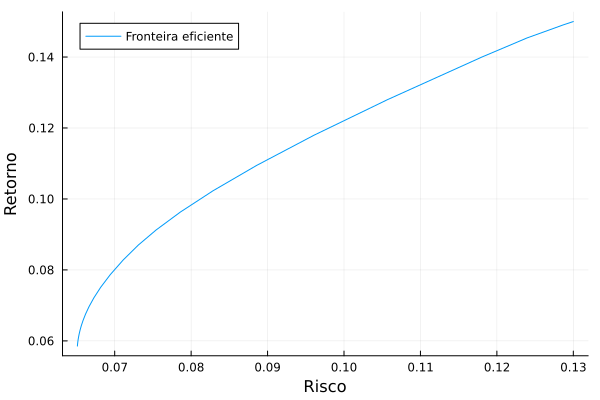

In [33]:
using Plots
plot(riscos, retornos, label = "Fronteira eficiente", xlabel = "Risco", ylabel = "Retorno")

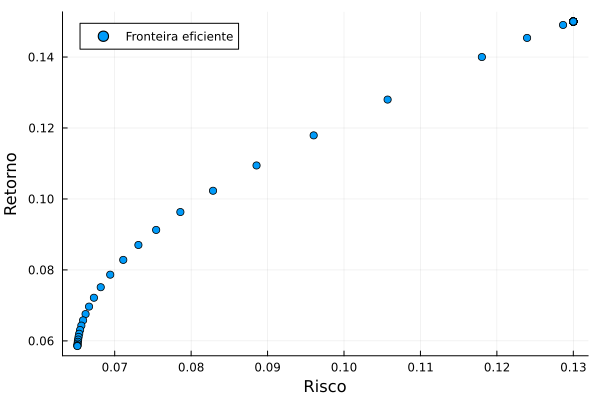

In [34]:
scatter(riscos, retornos, label = "Fronteira eficiente", xlabel = "Risco", ylabel = "Retorno")

In [35]:
ws

5×57 Matrix{Float64}:
 1.51469e-8  1.51639e-8  1.51841e-8  …  0.180499     0.18191     0.183047
 7.38819e-8  7.39654e-8  7.40723e-8     0.021024     0.0199277   0.018941
 3.20177e-8  3.20661e-8  3.21237e-8     0.182606     0.181418    0.180374
 1.51774e-8  1.52003e-8  1.52278e-8     0.615674     0.616743    0.617638
 1.0         1.0         1.0            0.000196785  2.18639e-7  9.85756e-8

## Comentários históricos

Na proposta original de Markowitz (de 1952), o método de resolução é geométrico, e corresponde ao que hoje chamaríamos da **versão multi-objetivo** do problema:
$$
\begin{aligned}
\max \; & (\mu^\top w, - w^\top \Sigma w) \\
\text{s.t.} \; & \sum_{i=1}^n w_i = 1, \\
        &  w_i \geq 0
\end{aligned}
$$

A segunda versão, de 1956, é praticamente equivalente à formulação de minimizar a variância, sujeito a um retorno mínimo.
Ela é mais algébrica (com considerações sobre o posto das matrizes e das equações envolvidas), e introduz os multiplicadores de Lagrange.

Neste artigo, Markowitz suspende temporariamente a restrição de positividade dos pesos,
o que permitiria que a solução ótima fosse "alavancada" com posições negativas ("a descoberto").
Naquela época, a solução de problemas de otimização com restrições de desigualdade não estava tão desenvolvida, e a formulação quadrática, penalizada, tinha a vantagem de não ter restrições de desigualdade, e portanto possuir uma fórmula fechada para o ótimo, o que permitia resolver muito mais rápido os problemas envolvidos.

In [36]:
λ = 8
mark_alav = Model(Ipopt.Optimizer);
@variable(mark_alav, w[1:n]);
@constraint(mark_alav, sum(w) == 1);
@objective(mark_alav, Max, μ'*w - λ * (w'*Σ*w));

In [37]:
set_silent(mark_alav)
optimize!(mark_alav)

In [38]:
solution_summary(mark_alav)

* Solver : Ipopt

* Status
  Result count       : 1
  Termination status : LOCALLY_SOLVED
  Message from the solver:
  "Solve_Succeeded"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Objective value    : 4.89753e-02
  Dual objective value : -1.13017e-02

* Work counters
  Solve time (sec)   : 3.00002e-03
  Barrier iterations : 1


Observe que a solução foi obtida em apenas um passo do solver (e não 9 e 11, como nos casos anteriores).

In [39]:
value.(mark_alav[:w])

5-element Vector{Float64}:
 -0.16458725628879464
 -0.027679052378440046
  0.20448445352625044
  0.45767640246316565
  0.5301054526778187

## Mais um pouco sobre terminologia e variáveis

Ao longo deste notebook, criamos vários modelos com uma variável de decisão $w$ ("matemática").
A cada vez, a macro `@constraint` criava uma variável ("programática") `w` correspondente.
Se uma variável com este nome já existia, ela era sobrescrita.

Mas as variáveis "de cada modelo" ainda podem ser acessadas a partir dos modelos correspondentes:

In [40]:
value.(w) # igual à mais recente

5-element Vector{Float64}:
 -0.16458725628879464
 -0.027679052378440046
  0.20448445352625044
  0.45767640246316565
  0.5301054526778187

In [41]:
value.(m[:w])

5-element Vector{Float64}:
 1.263337478748787e-6
 3.3441867361716786e-6
 0.17601118848905187
 0.3943909067578366
 0.42959329722889666

In [42]:
value.(markowitz[:w])

5-element Vector{Float64}:
 0.18304700121616144
 0.01894099209696816
 0.1803736597086673
 0.6176382484025656
 9.857563735431455e-8